In [1]:
import pandas as pd

dados = pd.read_csv('pareto.csv')
dados.head()

,features,probabilidade
0,Total Fwd Pkts,0.805593
1,Total Fwd Vol,0.404841
2,Total Bwd Pkts,0.145589
3,Total Bwd Vol,0.652177
4,Fwd Pkt Len Std,0.347817


In [5]:
!pip install -U pymoo

In [7]:
!pip install -U deslib

In [9]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import numpy as np
import pickle
from time import time
import os
import sys
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from deslib.des.knora_e import KNORAE
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

In [11]:
def LoadFeatures(path):

    df_train = pd.read_csv(path+'train.csv')
    X_train = df_train.drop('Label', axis=1) 
    y_train = df_train['Label']  

    df_test = pd.read_csv(path+'test.csv')
    X_test = df_test.drop('Label', axis=1) 
    y_test = df_test['Label']  

    df_test_ev = pd.read_csv(path+'test_evento.csv')
    #df_test_ev = df_test_ev.sample(frac=1).reset_index(drop=True)
    X_test_ev = df_test_ev.drop('Label', axis=1) 
    y_test_ev = df_test_ev['Label']  

    #return X_train, y_train, X_test[:1000], y_test[:1000], X_test_ev[:1000], y_test_ev[:1000]
    return X_train, y_train, X_test, y_test, X_test_ev, y_test_ev

In [13]:
# Definir o problema
class MyProblem(ElementwiseProblem):

    def __init__(self, *args):

        self.X_train = args[0]
        self.y_train = args[1]
        self.X_test = args[2]
        self.y_test = args[3]
        self.X_test_ev = args[4]
        self.y_test_ev = args[5]
        
        super().__init__(n_var=31,                 # Número de variáveis de decisão
                         n_obj=2,                 # Número de funções objetivo
                         n_constr=0,              # Número de restrições (se houver)
                         xl=np.zeros(31),     # Limites inferiores para cada variável
                         xu=np.ones(31))     # Limites superiores para cada variável


    # x = matriz com as variáveis definidas pelo algoritmo NSGA2.
    # out = retorna o resultado dos objetivos [acurácia e tempo].
    def _evaluate(self, x, out, *args, **kwargs):

        X_train = self.X_train
        y_train = self.y_train
        X_test = self.X_test
        y_test = self.y_test
        X_test_ev = self.X_test_ev
        y_test_ev = self.y_test_ev
        
        X_train, X_test, X_test_ev = self.AdjustFeatures(x, X_train, X_test, X_test_ev)

        f1, f2 = self.EvaluateModelErrorTime(X_train, X_test, X_test_ev, y_train, y_test, y_test_ev)

        # f1 = acurácia
        # f2 = tempo de inferência
        out["F"] = [f1, f2]

    def AdjustFeatures(self, x, x_train, x_test, x_test_ev):

        for i in range(len(x) -1, 0 , -1):
            if self.IsToDeleteFeature(x[i]):
                x_train = np.delete(x_train, i, 1)
                x_test = np.delete(x_test, i, 1)
                x_test_ev = np.delete(x_test_ev, i, 1)                
        return x_train, x_test, x_test_ev

    def IsToDeleteFeature(self,feature_value):
        return feature_value < 0.5

    def EvaluateModelErrorTime(self, x_train, x_test, x_test_ev, y_train, y_test, y_test_ev):

        y_pred, y_test, y_pred_ev, y_test_ev= self.GetPredictedClassification(x_train, x_test, x_test_ev, y_train, y_test, y_test_ev)

        accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
        accuracy2 = accuracy_score(y_true=y_test_ev, y_pred=y_pred_ev)
        
        print(f'Acurácia: {accuracy * 100:.4f}%')
        print(f'Acurácia Evento: {accuracy2 * 100:.4f}%')
        
        return (1 - accuracy, 1 - accuracy2)
    
    def GetPredictedClassification(self, x_train, x_test, x_test_ev, y_train, y_test, y_test_ev):
   
        model = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=16)
        model.fit(X=x_train, y=y_train)

        knorae = KNORAE(model)

        knorae.fit(x_train, y_train)
        
        #t0 = time()
        y_test_predict = knorae.predict(x_test)
        y_test_predict_ev = knorae.predict(x_test_ev)

        return y_test_predict, y_test, y_test_predict_ev, y_test_ev

In [6]:
def Minimize(problem):
    
    algorithm = NSGA2(pop_size=100, sampling=FloatRandomSampling())
    
    res = minimize(problem,
                   algorithm,
                   ('n_gen', 100),
                   seed=16,
                   verbose=True,
                   save_history=True)
    
    return res

In [15]:
import pickle
# Carregar o objeto 'res' de um arquivo
with open("res_nsga2.pkl", "rb") as file:
    res1 = pickle.load(file)

print("Objeto 'res' carregado com sucesso!")

Objeto 'res' carregado com sucesso!


In [17]:
def plotar2(res, indice):

    # ordena o resultado pela acurácia.
    res_sorted = res.F[res.F[:, 1].argsort()]
 
    plt.figure(figsize=(4.2, 4.2))

    # Coordenadas da melhor solução
    best_solution = res.F[indice]

    print(indice, best_solution[0], best_solution[1])
    # Destacar a melhor solução
    plt.scatter(
        best_solution[1], best_solution[0],
        color="red", label="Melhor solução", zorder=5
    )
    
    plt.plot(res_sorted[:, 1], res_sorted[:, 0], color='orange', linewidth=2)
    plt.xticks(rotation=45, ha='right')
    plt.autoscale(tight=True)
    
    plt.xlabel("Dgen")
    plt.ylabel("Dtest", labelpad=1)
    plt.tick_params(axis='both', which='major', pad=0) 
    
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.3f}'))
    
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [37]:
def plotar_grafico(res, indice):

    # ordena o resultado pela acurácia.
    res_sorted = res.F[res.F[:, 1].argsort()]
    res_sorted = res_sorted * 100
    # Habilitar o uso de LaTeX no Matplotlib
    plt.rc('text', usetex=True)
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rc('font', size=12)
    
    plt.figure(figsize=(4, 4))

    # Coordenadas da melhor solução
    best_solution = res.F[indice]
    best_solution = best_solution * 100
    
    #print(indice, best_solution[0], best_solution[1])
    # Destacar a melhor solução
    plt.scatter(
        best_solution[1], best_solution[0],
        color="red", label="Best Solution", zorder=5
    )

    plt.annotate(
    "Ponto de Operação",  # Texto da anotação
    (best_solution[1], best_solution[0]),  # Coordenadas do ponto
    textcoords="offset points",  # Sistema de coordenadas para o texto
    xytext=(50, 20),  # Offset da posição do texto
    ha='center',  # Alinhamento horizontal
    fontsize=12,  # Tamanho da fonte
    color='black',  # Cor do texto
    arrowprops=dict(
        arrowstyle="->",  # Tipo de seta
        color='black',  # Cor da seta
        lw=1.0  # Largura da linha da seta
    )
)
    
    plt.plot(res_sorted[:, 1], res_sorted[:, 0], linewidth=3, color="black", linestyle=":")
    #plt.xticks(rotation=0, ha='right')
    #plt.autoscale(tight=True)
    
    plt.xlabel("$\mathcal{D}_{gen}$ (\%)", fontsize=16)
    plt.ylabel("$\mathcal{D}_{test}$ (\%)", labelpad=1, fontsize=16)
    #plt.tick_params(axis='both', which='major', pad=0) 
    
    plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    
    plt.margins(x=0, y=0)
    #plt.tight_layout()

    plt.savefig("pareto.pdf", format="pdf", bbox_inches='tight')
    
    plt.show()

0 0.0010463491766576904 0.0


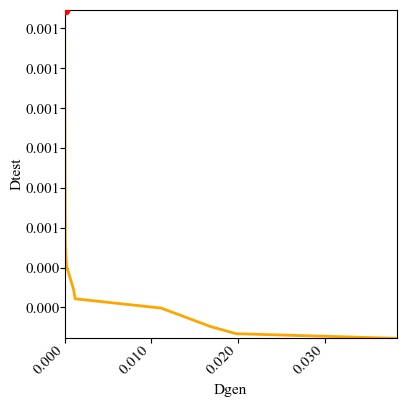

1 0.0010463491766576904 0.0


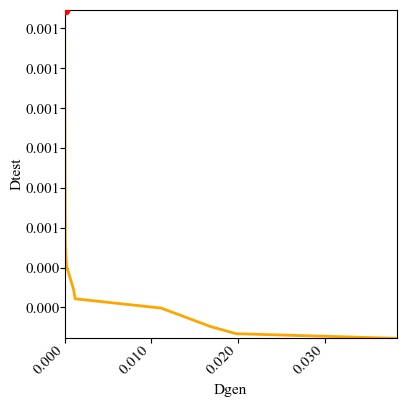

2 0.00022212999281001622 0.038346171381949956


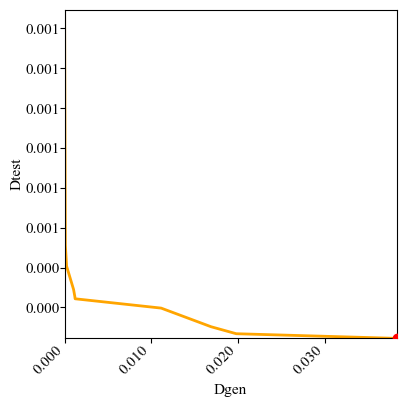

3 0.00022212999281001622 0.038346171381949956


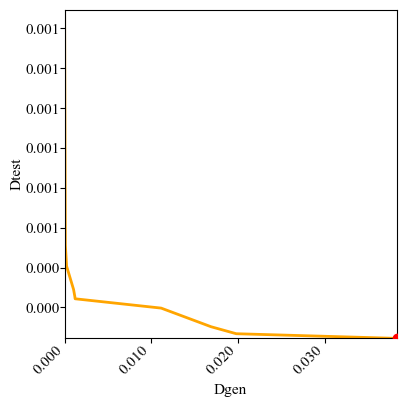

4 0.00045595103787321456 8.398723394043017e-05


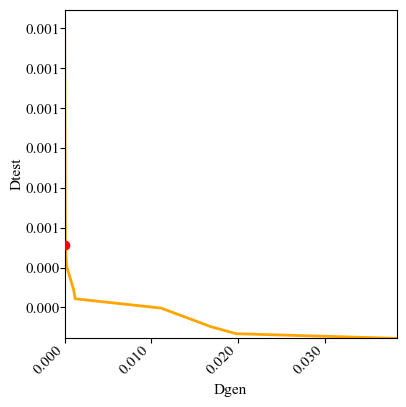

5 0.00023382104506319834 0.01979699085738973


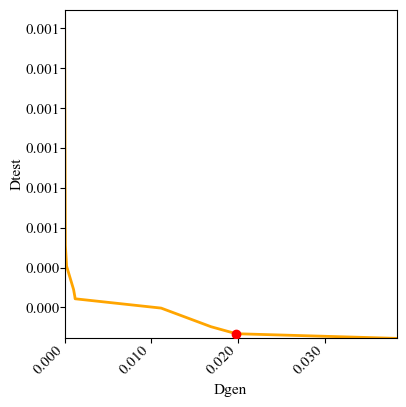

6 0.00029812183245547796 0.011134307585247027


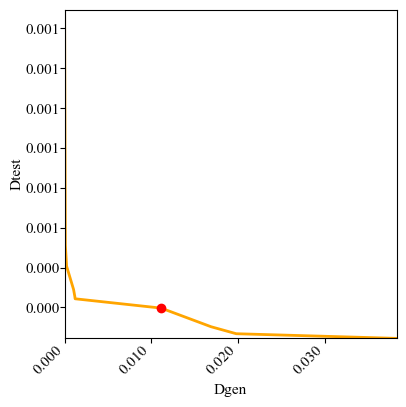

7 0.0003215039369618422 0.0012118158039977622


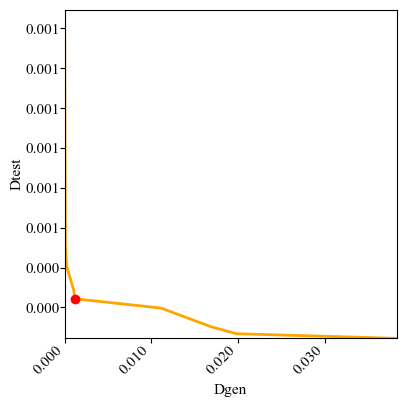

8 0.00029812183245547796 0.011134307585247027


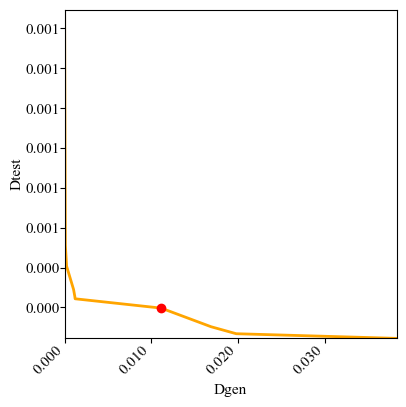

9 0.0002513576234428605 0.016893432198305858


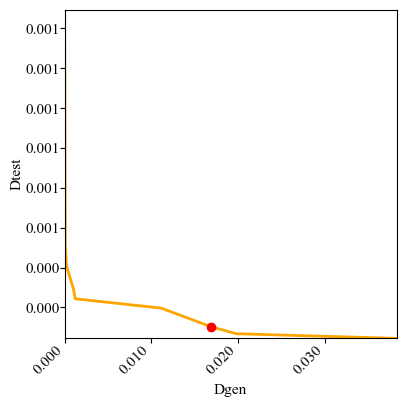

10 0.0002513576234428605 0.016893432198305858


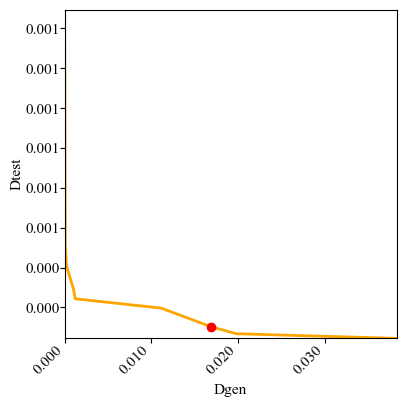

11 0.00023382104506319834 0.01979699085738973


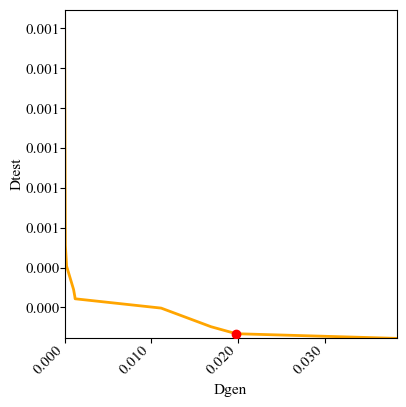

12 0.00040334130273400604 0.00022796534926694534


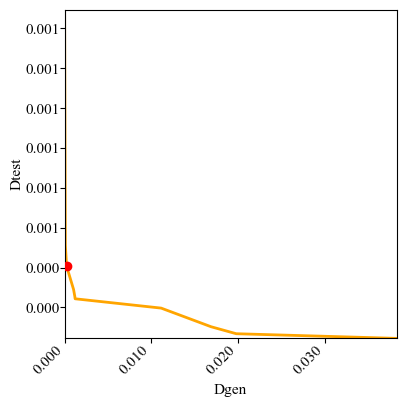

13 0.00040334130273400604 0.00022796534926694534


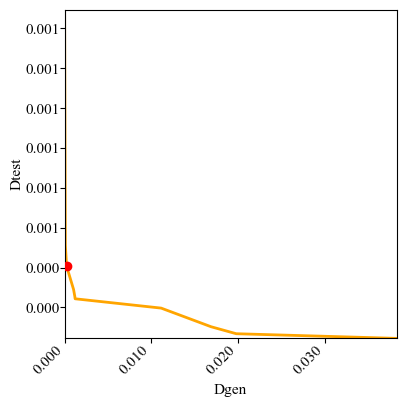

14 0.00034488604146820645 0.0010318431598397293


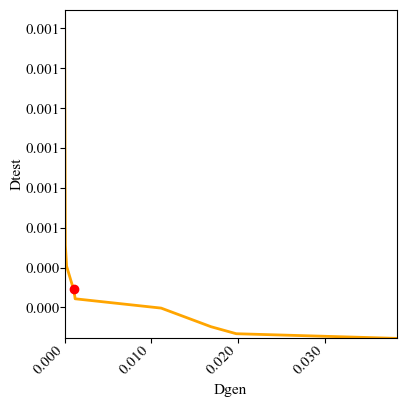

15 0.00045595103787321456 8.398723394043017e-05


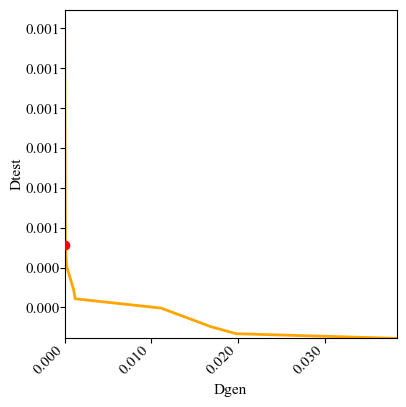

16 0.00034488604146820645 0.0010318431598397293


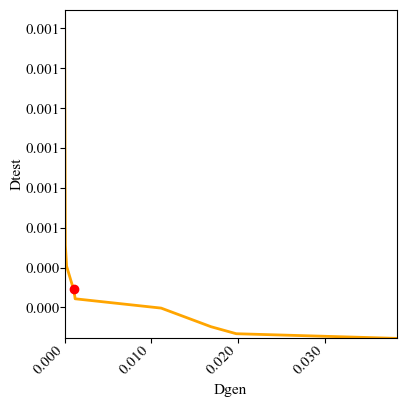

17 0.0003215039369618422 0.0012118158039977622


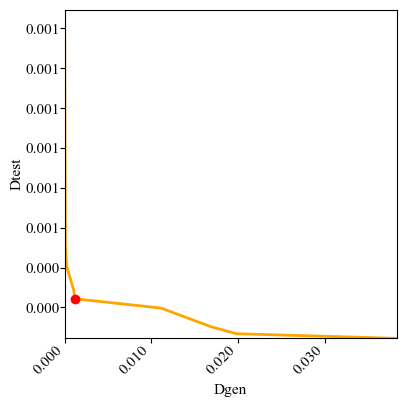

18 0.00032734946308843327 0.0011758212751661334


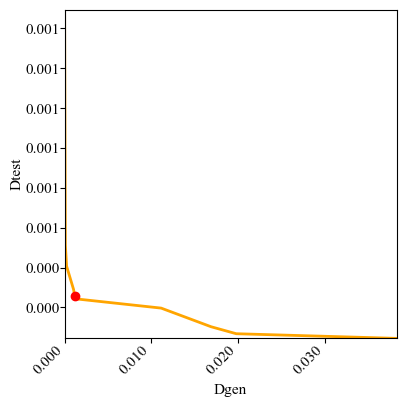

19 0.00032734946308843327 0.0011758212751661334


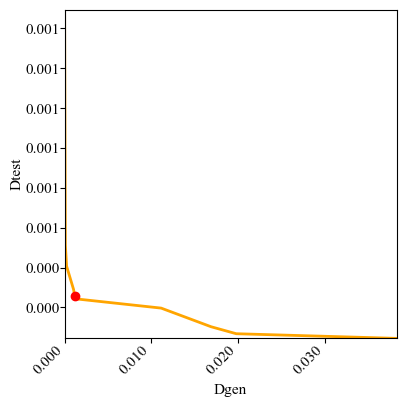

20 0.00034488604146820645 0.0010318431598397293


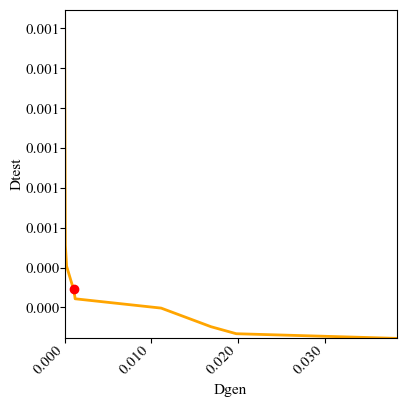

21 0.00032734946308843327 0.0011758212751661334


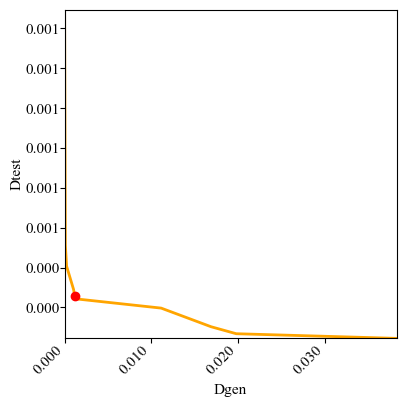

22 0.0003215039369618422 0.0012118158039977622


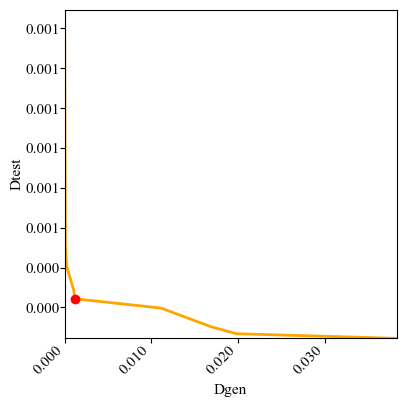

23 0.00023382104506319834 0.01979699085738973


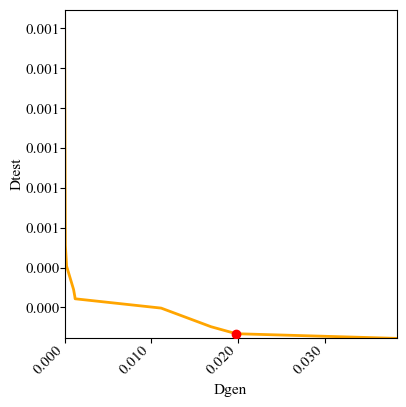

24 0.00032734946308843327 0.0011758212751661334


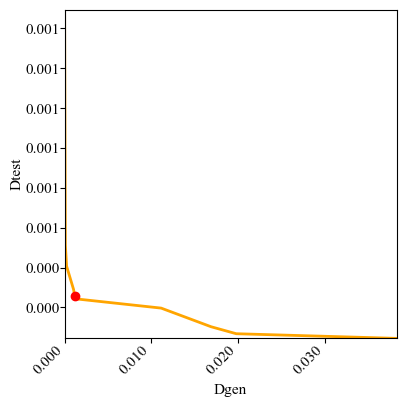

25 0.00032734946308843327 0.0011758212751661334


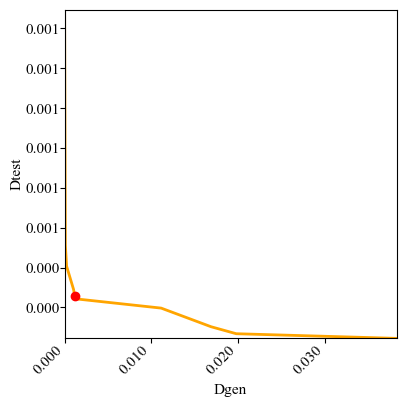

26 0.00032734946308843327 0.0011758212751661334


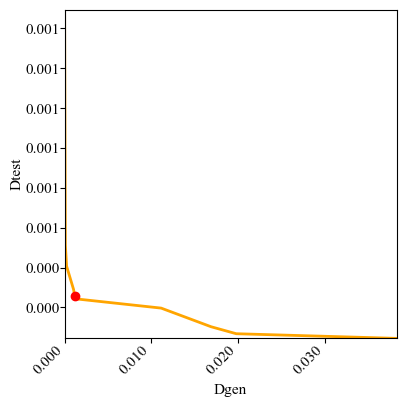

27 0.00032734946308843327 0.0011758212751661334


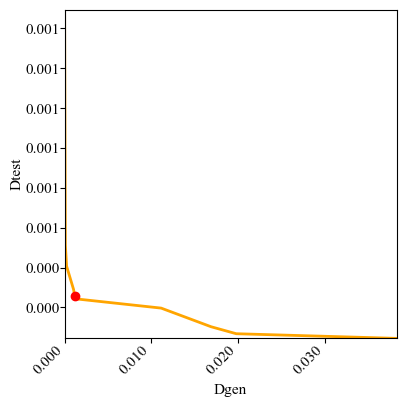

28 0.00032734946308843327 0.0011758212751661334


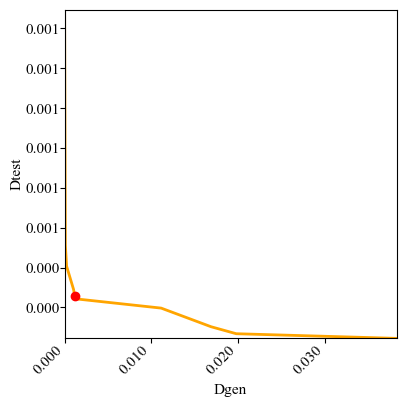

29 0.00032734946308843327 0.0011758212751661334


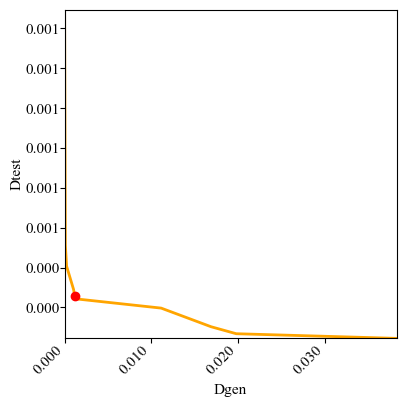

30 0.00032734946308843327 0.0011758212751661334


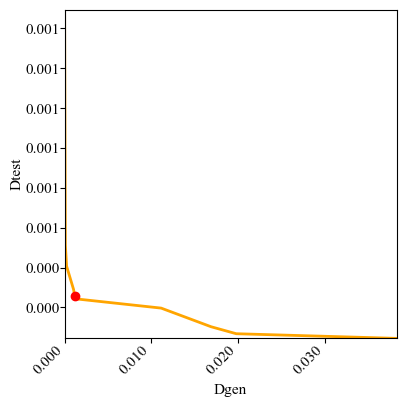

31 0.00034488604146820645 0.0010318431598397293


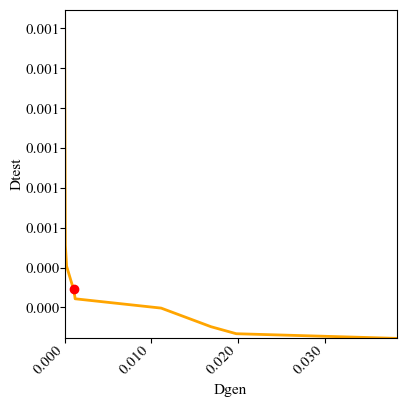

32 0.00032734946308843327 0.0011758212751661334


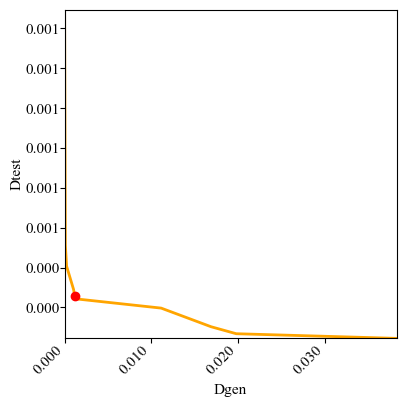

33 0.00032734946308843327 0.0011758212751661334


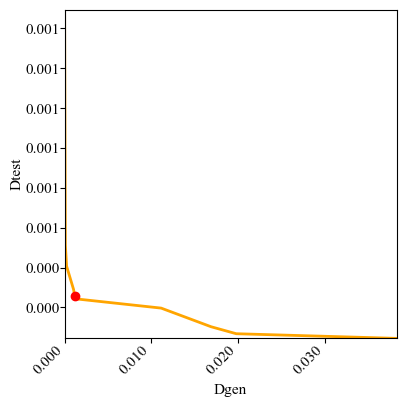

34 0.00032734946308843327 0.0011758212751661334


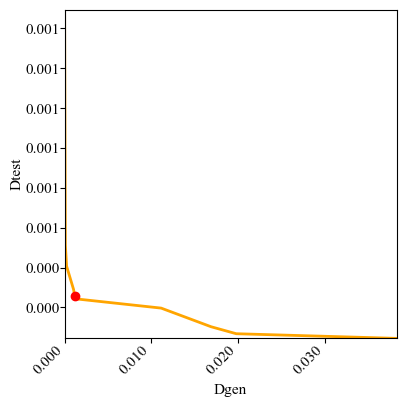

35 0.00022212999281001622 0.038346171381949956


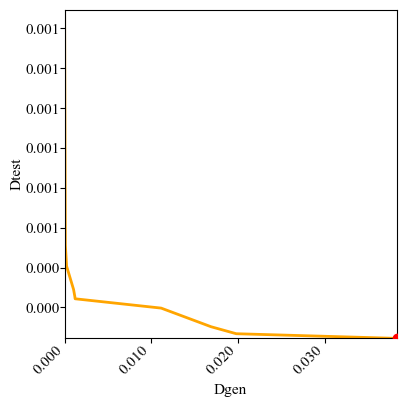

36 0.00032734946308843327 0.0011758212751661334


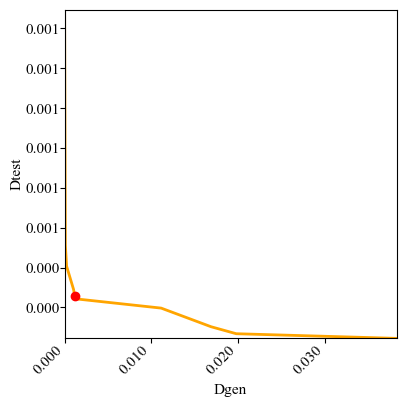

37 0.00032734946308843327 0.0011758212751661334


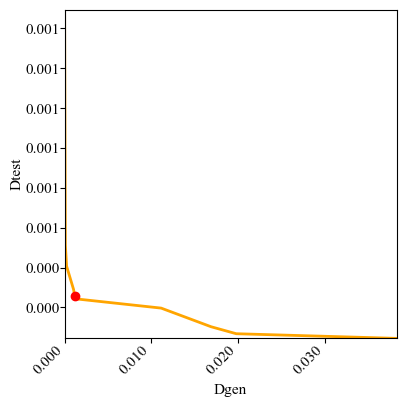

38 0.0003215039369618422 0.0012118158039977622


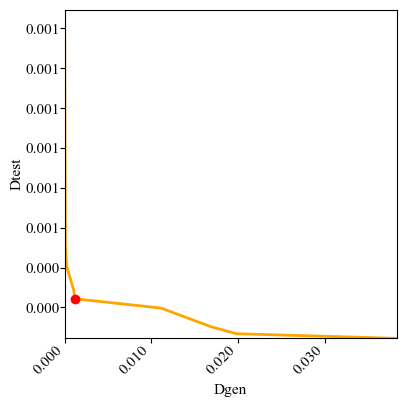

39 0.0003215039369618422 0.0012118158039977622


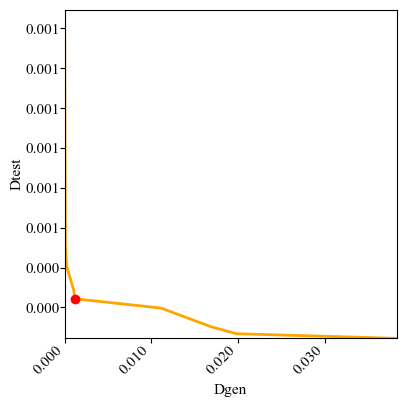

40 0.00032734946308843327 0.0011758212751661334


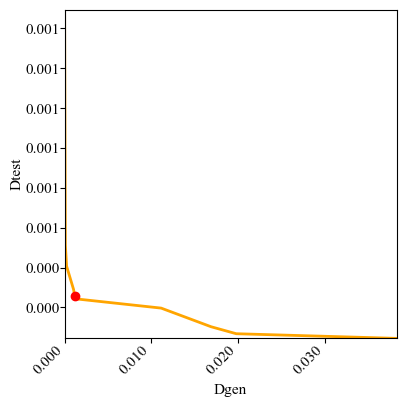

41 0.00022212999281001622 0.038346171381949956


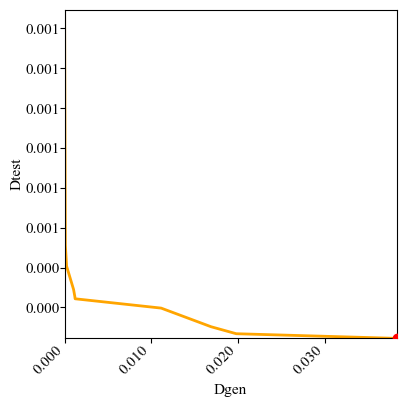

42 0.00040334130273400604 0.00022796534926694534


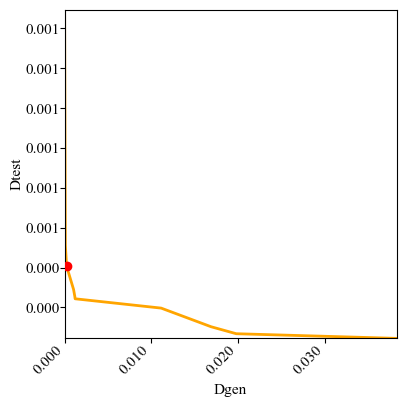

43 0.0003215039369618422 0.0012118158039977622


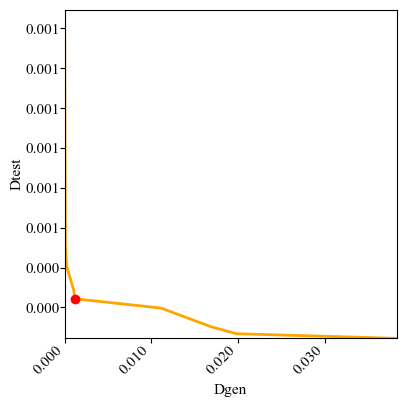

44 0.00032734946308843327 0.0011758212751661334


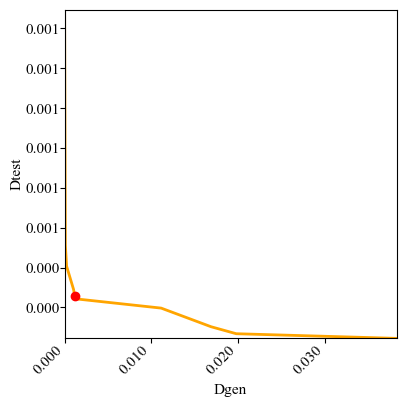

45 0.00040334130273400604 0.00022796534926694534


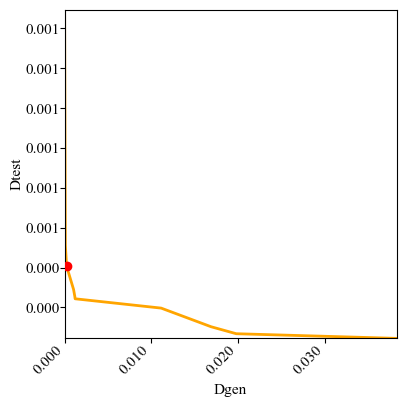

46 0.00022212999281001622 0.038346171381949956


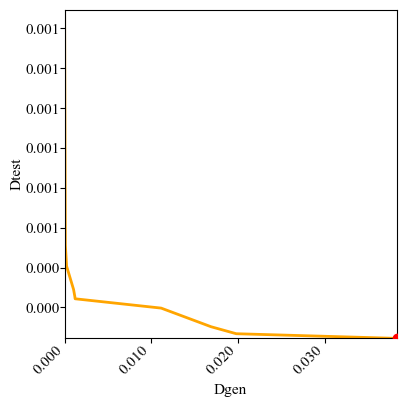

47 0.00032734946308843327 0.0011758212751661334


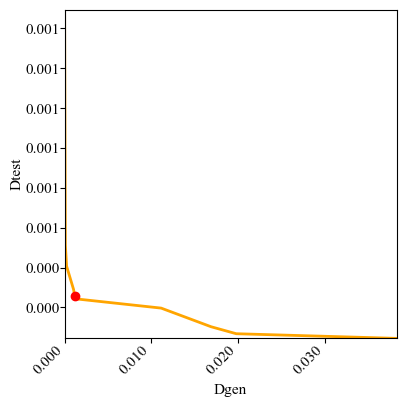

48 0.00034488604146820645 0.0010318431598397293


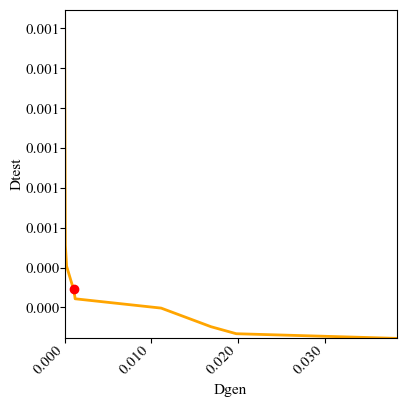

49 0.0003215039369618422 0.0012118158039977622


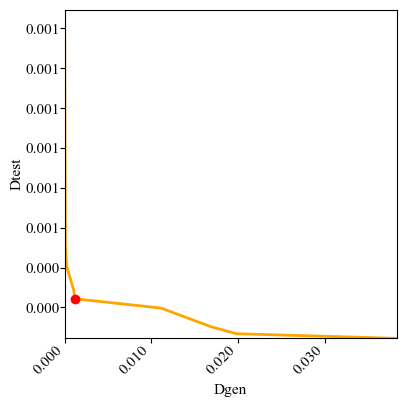

50 0.00032734946308843327 0.0011758212751661334


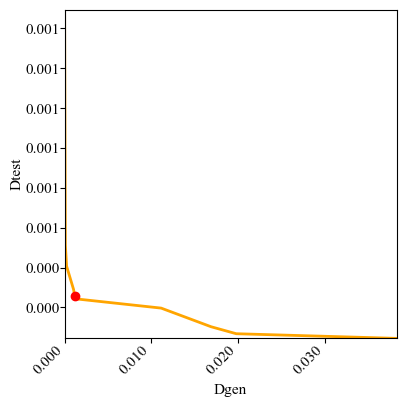

51 0.00040334130273400604 0.00022796534926694534


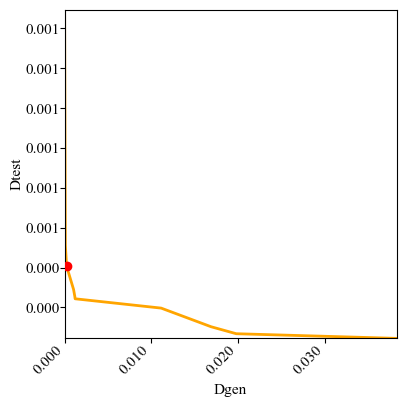

52 0.00023382104506319834 0.01979699085738973


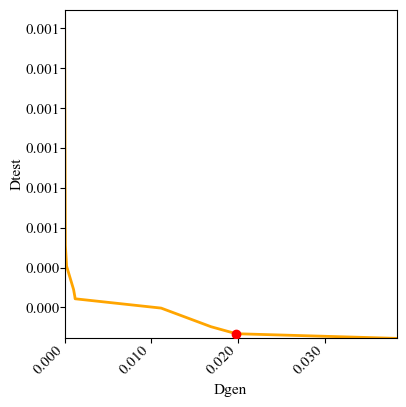

53 0.00032734946308843327 0.0011758212751661334


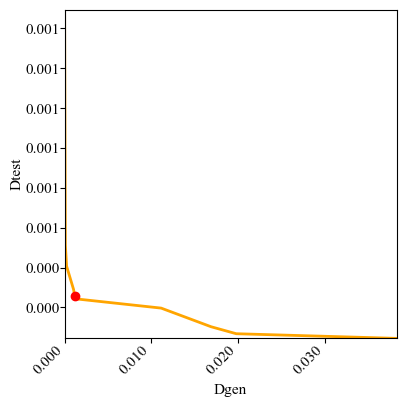

54 0.0002513576234428605 0.016893432198305858


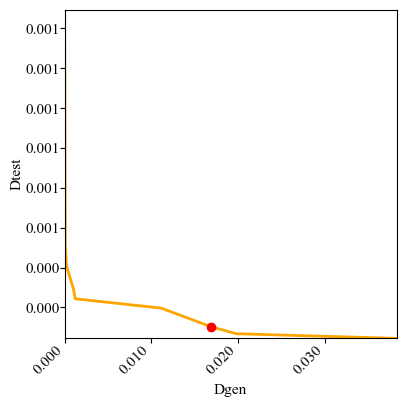

55 0.00023382104506319834 0.01979699085738973


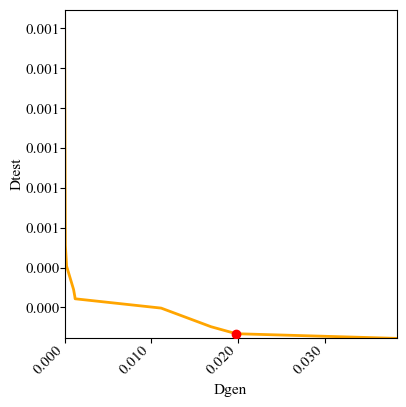

56 0.00022212999281001622 0.038346171381949956


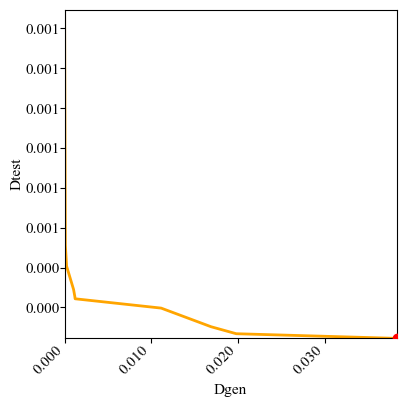

57 0.00034488604146820645 0.0010318431598397293


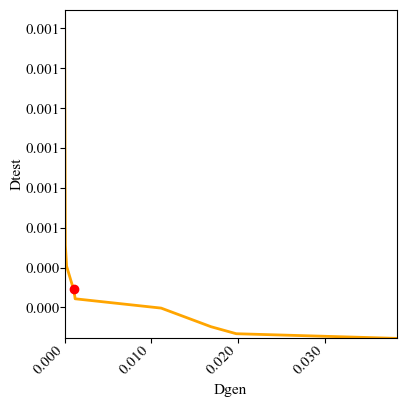

58 0.00029812183245547796 0.011134307585247027


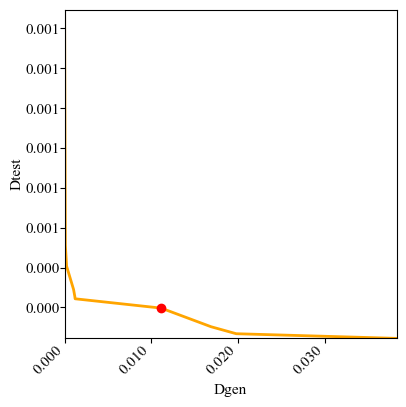

59 0.00040334130273400604 0.00022796534926694534


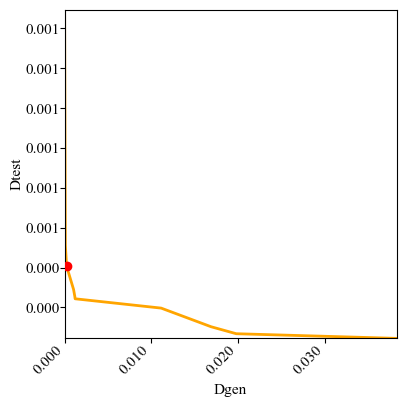

60 0.00032734946308843327 0.0011758212751661334


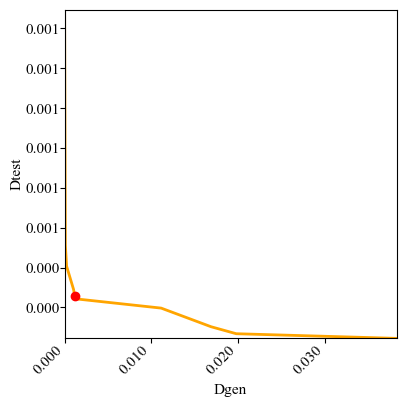

61 0.00032734946308843327 0.0011758212751661334


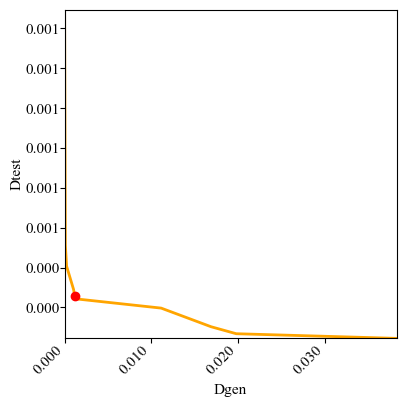

62 0.00029812183245547796 0.011134307585247027


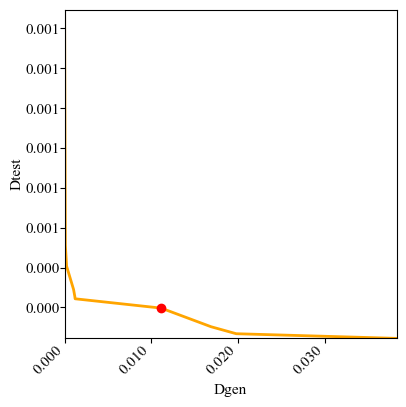

63 0.00032734946308843327 0.0011758212751661334


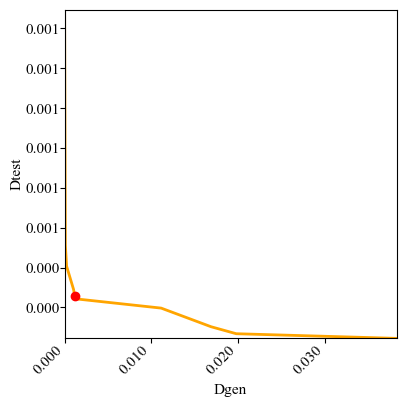

64 0.0002513576234428605 0.016893432198305858


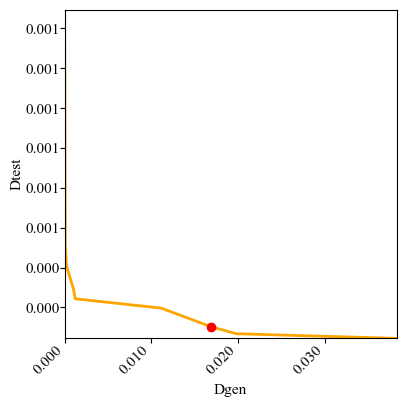

65 0.0002513576234428605 0.016893432198305858


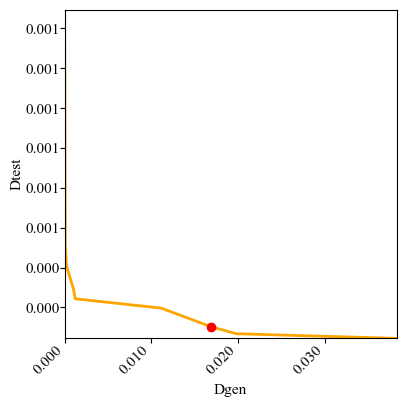

66 0.00034488604146820645 0.0010318431598397293


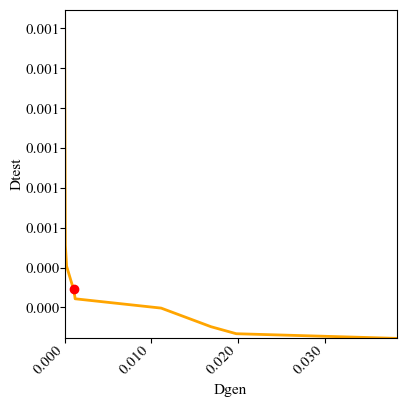

67 0.00034488604146820645 0.0010318431598397293


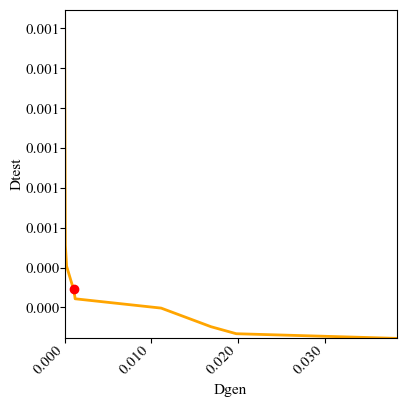

68 0.00032734946308843327 0.0011758212751661334


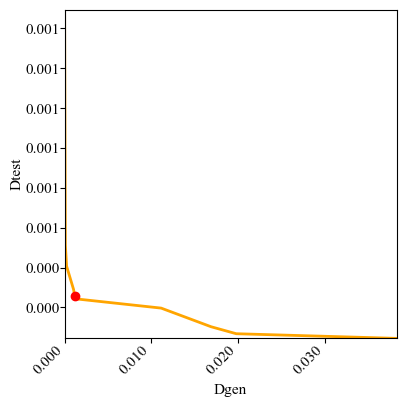

69 0.0002513576234428605 0.016893432198305858


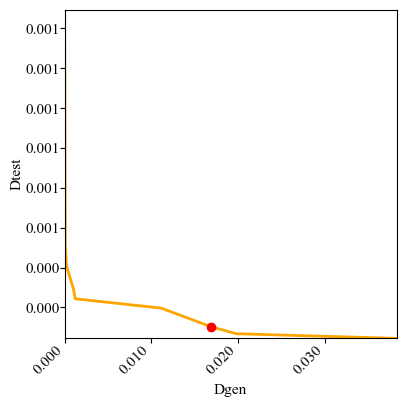

70 0.00032734946308843327 0.0011758212751661334


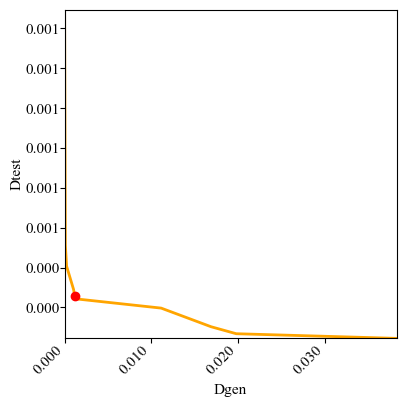

71 0.00023382104506319834 0.01979699085738973


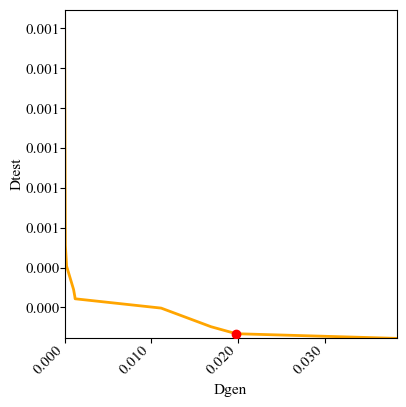

72 0.00032734946308843327 0.0011758212751661334


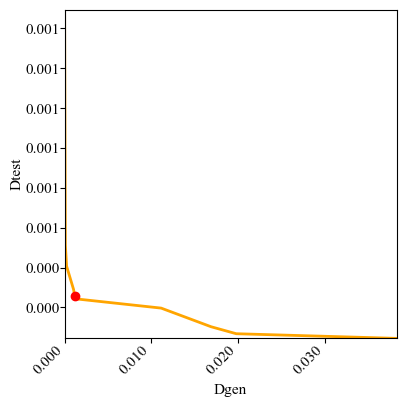

73 0.00032734946308843327 0.0011758212751661334


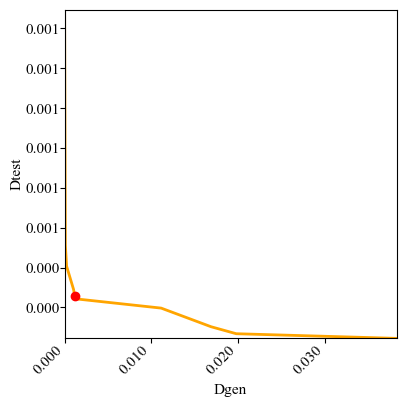

74 0.00032734946308843327 0.0011758212751661334


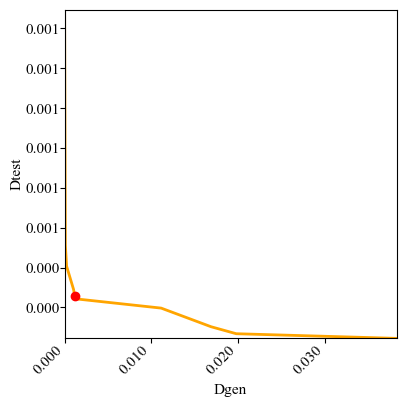

75 0.00032734946308843327 0.0011758212751661334


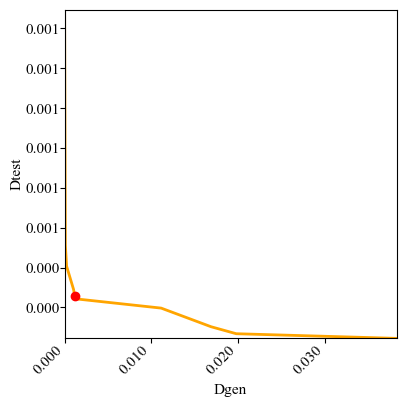

76 0.00032734946308843327 0.0011758212751661334


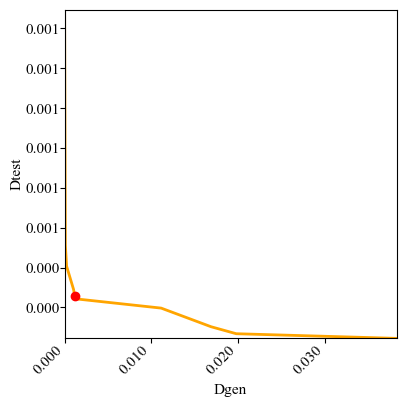

77 0.0003215039369618422 0.0012118158039977622


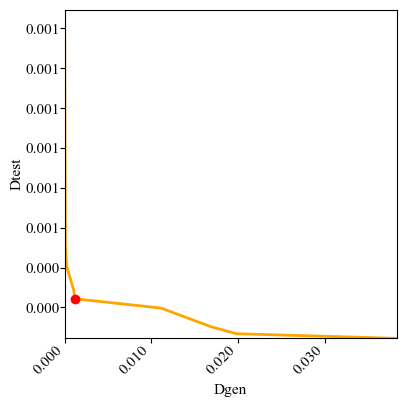

78 0.00032734946308843327 0.0011758212751661334


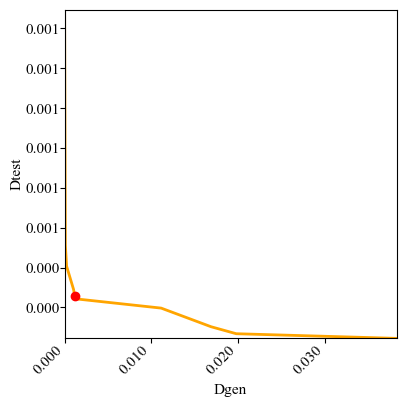

79 0.00032734946308843327 0.0011758212751661334


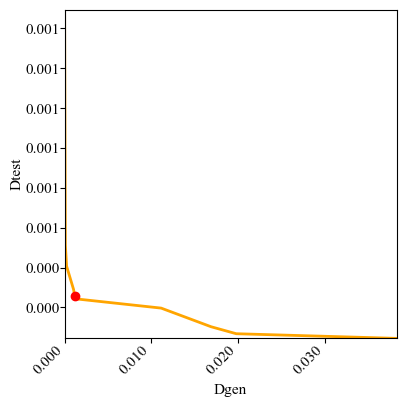

80 0.00032734946308843327 0.0011758212751661334


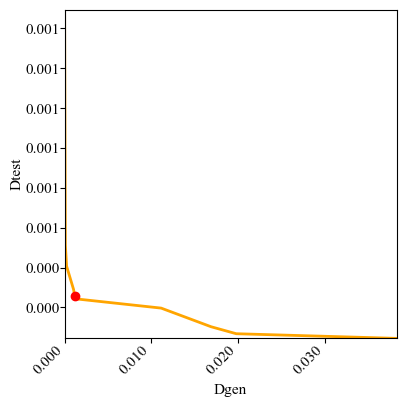

81 0.00040334130273400604 0.00022796534926694534


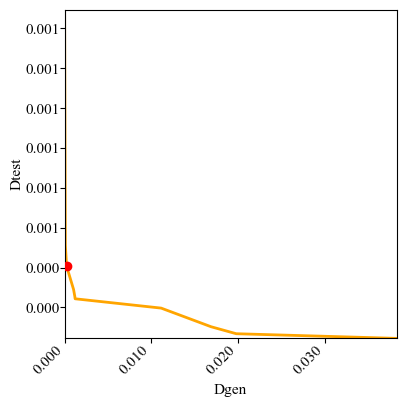

82 0.00032734946308843327 0.0011758212751661334


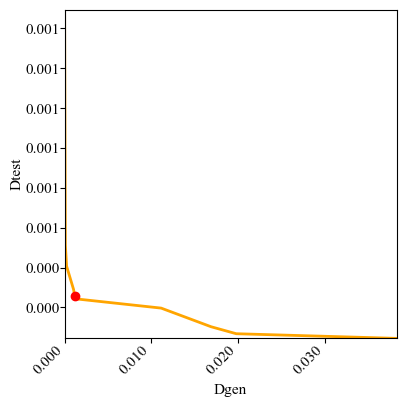

83 0.00034488604146820645 0.0010318431598397293


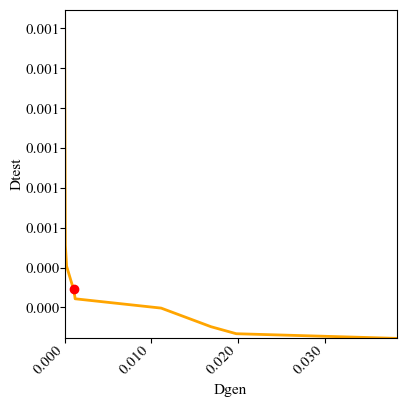

84 0.0002513576234428605 0.016893432198305858


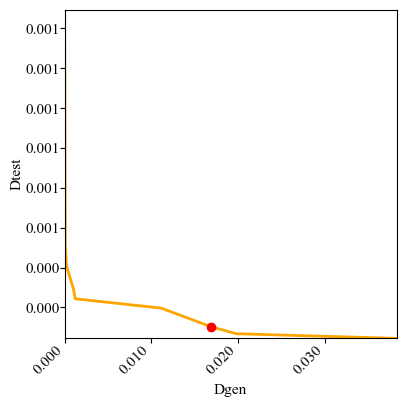

85 0.00032734946308843327 0.0011758212751661334


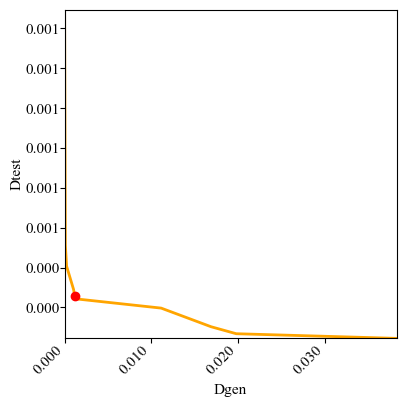

86 0.0003215039369618422 0.0012118158039977622


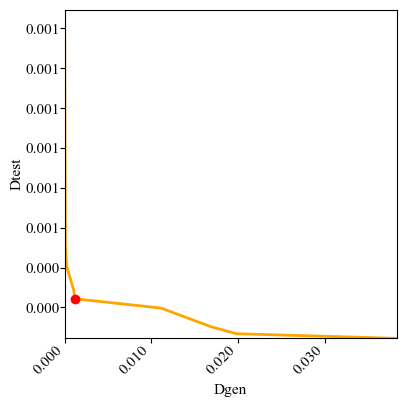

87 0.00032734946308843327 0.0011758212751661334


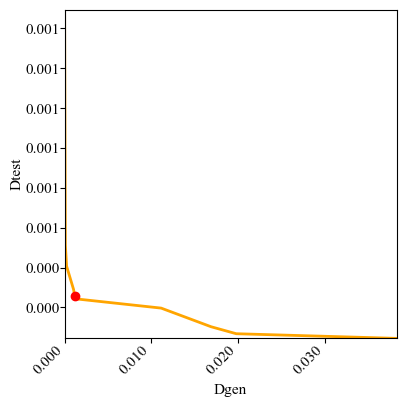

88 0.00032734946308843327 0.0011758212751661334


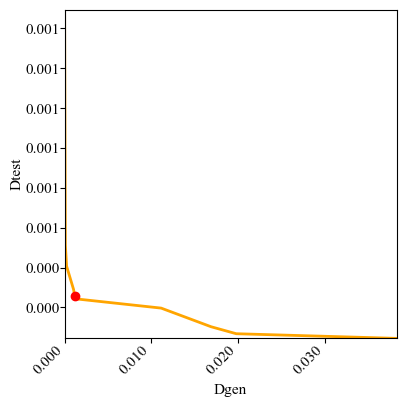

89 0.00032734946308843327 0.0011758212751661334


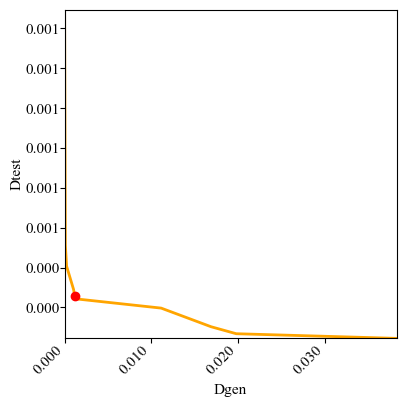

90 0.00032734946308843327 0.0011758212751661334


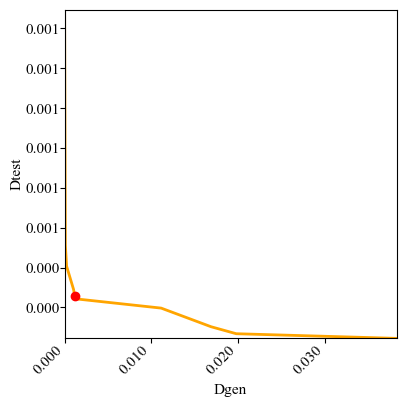

91 0.00032734946308843327 0.0011758212751661334


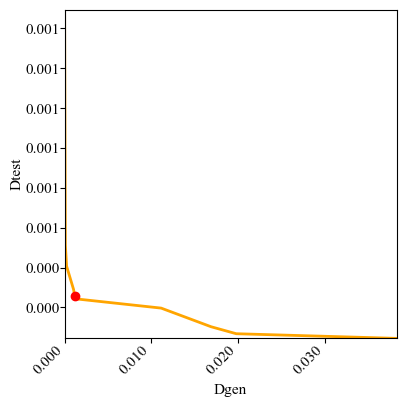

92 0.00032734946308843327 0.0011758212751661334


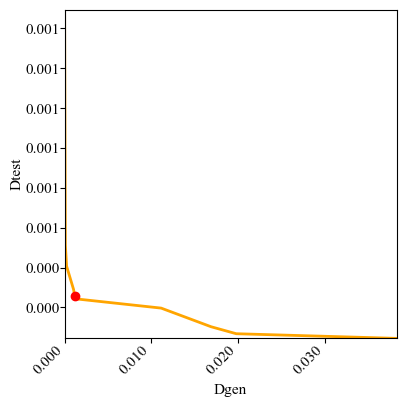

93 0.00032734946308843327 0.0011758212751661334


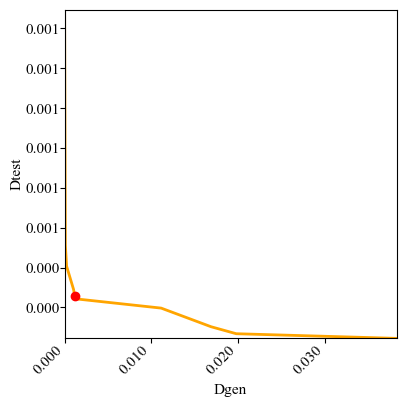

94 0.00040334130273400604 0.00022796534926694534


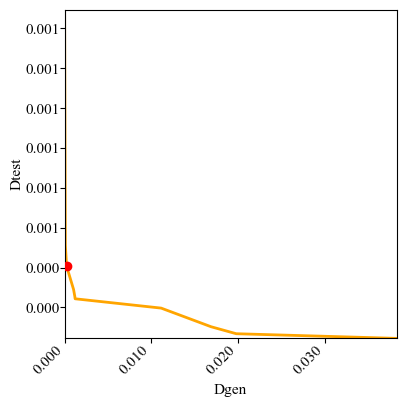

95 0.00032734946308843327 0.0011758212751661334


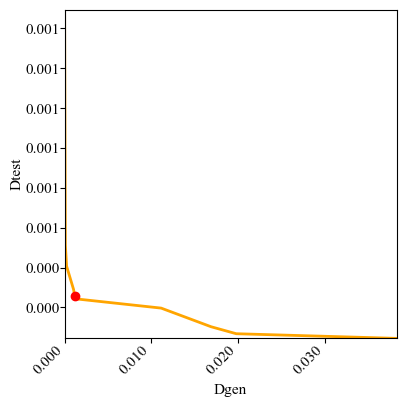

96 0.00032734946308843327 0.0011758212751661334


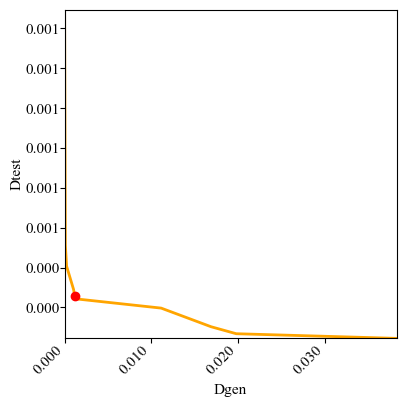

97 0.00022212999281001622 0.038346171381949956


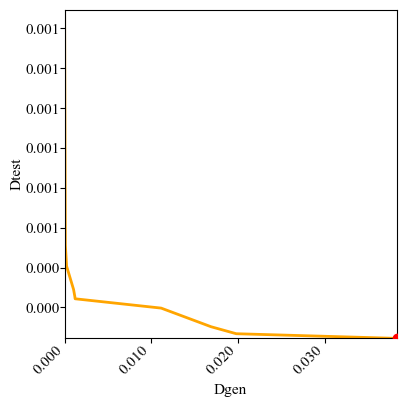

98 0.00023382104506319834 0.01979699085738973


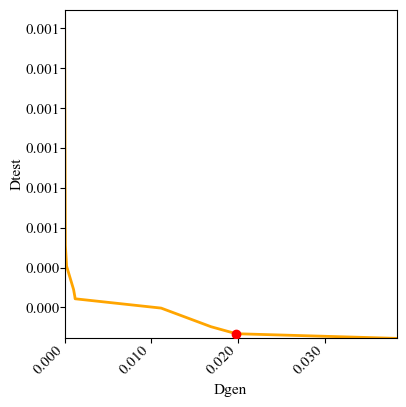

99 0.00032734946308843327 0.0011758212751661334


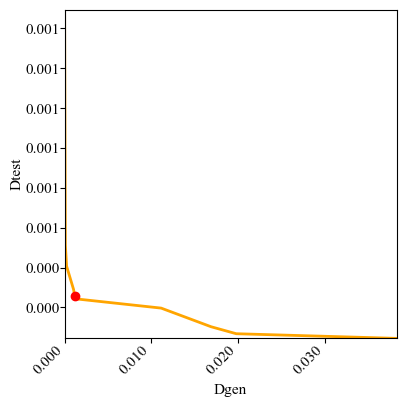

In [21]:
for i in range(0,100):
    plotar2(res1, i)

In [22]:
res1.F[7]

array([0.0003215 , 0.00121182])

7 0.0003215039369618422 0.0012118158039977622


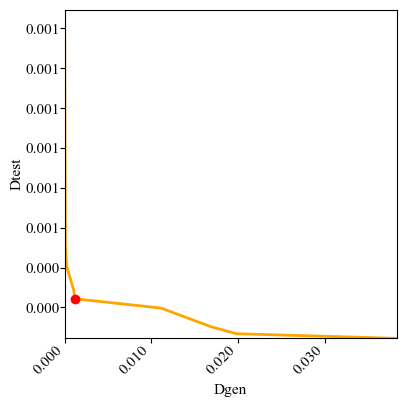

In [25]:
plotar2(res1, 7)

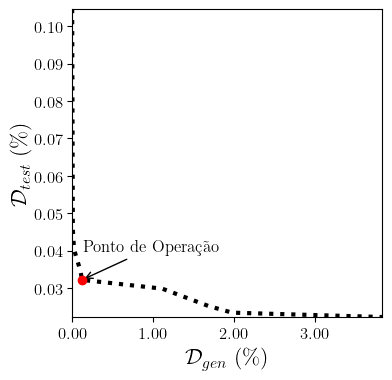

In [39]:
plotar_grafico(res1, 7)

In [41]:
res_sorted = res1.F[res1.F[:, 1].argsort()]
res_sorted = res_sorted * 100

In [43]:
res_sorted

array([[0.10463492, 0.        ],
       [0.10463492, 0.        ],
       [0.0455951 , 0.00839872],
       [0.0455951 , 0.00839872],
       [0.04033413, 0.02279653],
       [0.04033413, 0.02279653],
       [0.04033413, 0.02279653],
       [0.04033413, 0.02279653],
       [0.04033413, 0.02279653],
       [0.04033413, 0.02279653],
       [0.04033413, 0.02279653],
       [0.04033413, 0.02279653],
       [0.0344886 , 0.10318432],
       [0.0344886 , 0.10318432],
       [0.0344886 , 0.10318432],
       [0.0344886 , 0.10318432],
       [0.0344886 , 0.10318432],
       [0.0344886 , 0.10318432],
       [0.0344886 , 0.10318432],
       [0.0344886 , 0.10318432],
       [0.0344886 , 0.10318432],
       [0.03273495, 0.11758213],
       [0.03273495, 0.11758213],
       [0.03273495, 0.11758213],
       [0.03273495, 0.11758213],
       [0.03273495, 0.11758213],
       [0.03273495, 0.11758213],
       [0.03273495, 0.11758213],
       [0.03273495, 0.11758213],
       [0.03273495, 0.11758213],
       [0.

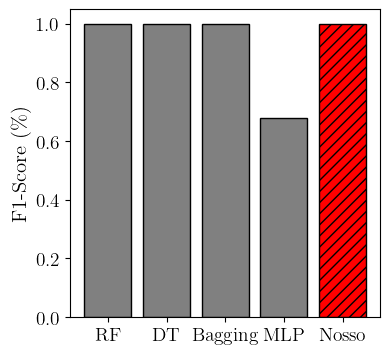

In [99]:
import matplotlib.pyplot as plt


plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=12)    

classifiers = ['RF', 'DT', 'Bagging', 'MLP', 'Nosso']
values = [1.000, 0.999, 0.998, 0.679, 1.000]

# Configuração do gráfico
colors = ['gray', 'gray', 'gray', 'gray', 'red']
hatches = ['', '', '', '', '///']  # Padrão tracejado para "Ours"

# Configuração do gráfico
plt.figure(figsize=(4, 4))
plt.bar(classifiers, values, color=colors, edgecolor='black', hatch=hatches)
#plt.xlabel('Classifiers', fontsize=16)
#plt.ylabel('F1-Scores', fontsize=16)


plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.ylabel('F1-Score (\%)', fontsize=15)

# Salvar o gráfico em PDF
plt.savefig('Fig5a.pdf', format='pdf', bbox_inches='tight')
plt.show()

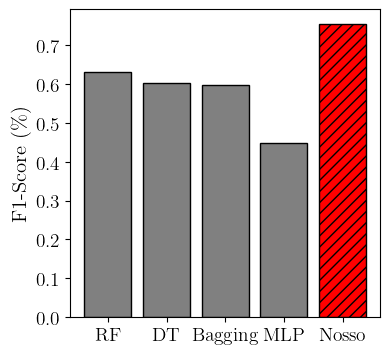

In [97]:
import matplotlib.pyplot as plt


plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=12)    

classifiers = ['RF', 'DT', 'Bagging', 'MLP', 'Nosso']
values = [0.632, 0.602, 0.597, 0.449, 0.756]

# Configuração do gráfico
colors = ['gray', 'gray', 'gray', 'gray', 'red']
hatches = ['', '', '', '', '///']  # Padrão tracejado para "Ours"

# Configuração do gráfico
plt.figure(figsize=(4, 4))
plt.bar(classifiers, values, color=colors, edgecolor='black', hatch=hatches)
#plt.xlabel('Classifiers', fontsize=16)
#plt.ylabel('F1-Scores', fontsize=16)


plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')
plt.ylabel('F1-Score (\%)', fontsize=15)

# Salvar o gráfico em PDF
plt.savefig('Fig5b.pdf', format='pdf', bbox_inches='tight')
plt.show()

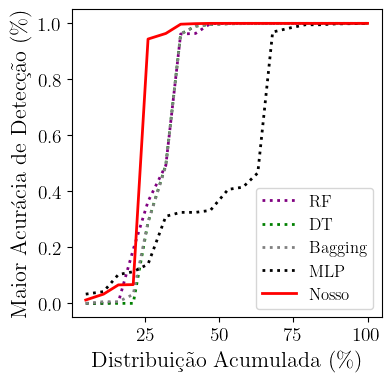

In [75]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=14)  

# Dados fornecidos
behavior = [5, 11, 16, 21, 26, 32, 37, 42, 47, 53, 58, 63, 68, 74, 79, 84, 89, 95, 100]
rf = [0.000, 0.000, 0.004, 0.192, 0.364, 0.493, 0.962, 0.964, 0.999, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]
dt = [0.000, 0.000, 0.000, 0.000, 0.290, 0.495, 0.962, 0.990, 0.996, 0.999, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]
bagging = [0.000, 0.006, 0.006, 0.032, 0.290, 0.491, 0.962, 0.990, 0.996, 0.998, 0.999, 0.999, 0.999, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]
mlp = [0.033, 0.042, 0.103, 0.113, 0.140, 0.311, 0.325, 0.325, 0.332, 0.407, 0.415, 0.466, 0.969, 0.984, 0.995, 0.995, 0.998, 0.999, 1.000]
ours = [0.012, 0.033, 0.066, 0.067, 0.944, 0.964, 0.997, 0.999, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000, 1.000]

# Criando o gráfico
plt.figure(figsize=(4, 4))

# Plotando as curvas para cada algoritmo
plt.plot(behavior, rf, label='RF', color='purple', linewidth=2, linestyle=':')
plt.plot(behavior, dt, label='DT', color='green', linewidth=2, linestyle=':')
plt.plot(behavior, bagging, label='Bagging', color='gray', linewidth=2, linestyle=':')
plt.plot(behavior, mlp, label='MLP', color='black', linewidth=2, linestyle=':')
#plt.plot(behavior, ours, label='Ours', color='red', linewidth=2)
plt.plot(behavior, ours, label='Nosso', color='red', linewidth=2)


# Adicionando título e rótulos
plt.xlabel('Distribuição Acumulada (\%)', fontsize=16)
plt.ylabel('Maior Acurácia de Detecção  (\%)', fontsize=16)

# Adicionando legenda
plt.legend(fontsize=12)

plt.savefig('cdf.pdf', format='pdf', bbox_inches='tight')

plt.show()

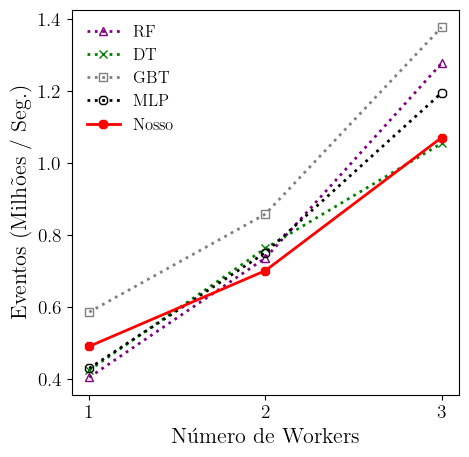

In [147]:
# Gráfico BIGDATA
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=14)  

# Dados fornecidos
behavior = [1, 2, 3]
dt = [0.426, 0.764, 1.055]
gbt = [0.587, 0.859, 1.377]
mlp = [0.431, 0.752, 1.195]
rf = [0.406, 0.737, 1.277]
ours = [0.492, 0.702, 1.071]

# Criando o gráfico
plt.figure(figsize=(5, 5))

# Plotando as curvas para cada algoritmo
plt.plot(behavior, rf, label='RF', color='purple', linewidth=2, linestyle=':', marker="^", markerfacecolor='none')
plt.plot(behavior, dt, label='DT', color='green', linewidth=2, linestyle=':', marker="x", markerfacecolor='none')
plt.plot(behavior, gbt, label='GBT', color='gray', linewidth=2, linestyle=':', marker="s", markerfacecolor='none')
plt.plot(behavior, mlp, label='MLP', color='black', linewidth=2, linestyle=':', marker="8", markerfacecolor='none')
#plt.plot(behavior, ours, label='Ours', color='red', linewidth=2)
plt.plot(behavior, ours, label='Nosso', color='red', linewidth=2, marker="8")

plt.xticks(behavior)

# Adicionando título e rótulos
plt.xlabel('Número de Workers', fontsize=16)
plt.ylabel('Eventos (Milhões / Seg.)', fontsize=16)

# Adicionando legenda
plt.legend(fontsize=12, frameon=False)

plt.savefig('inference1.pdf', format='pdf', bbox_inches='tight')

plt.show()

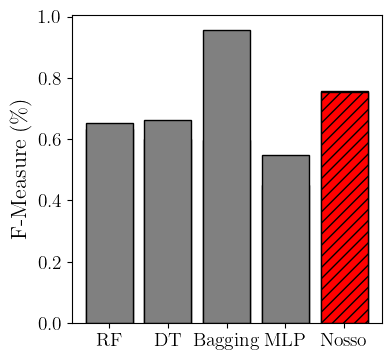

In [81]:
import matplotlib.pyplot as plt


plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=12)    

classifiers = ['RF', 'DT', 'Bagging', 'MLP', 'Nosso']
values = [0.632, 0.602, 0.597, 0.449, 0.756]
values1 = [0.652, 0.662, 0.957, 0.549, 0.754]

# Configuração do gráfico
colors = ['gray', 'gray', 'gray', 'gray', 'red']
hatches = ['', '', '', '', '///']  # Padrão tracejado para "Ours"

# Configuração do gráfico
plt.figure(figsize=(4, 4))
plt.bar(classifiers, values, color=colors, edgecolor='black', hatch=hatches)
plt.bar(classifiers, values1, color=colors, edgecolor='black', hatch=hatches)
#plt.xlabel('Classifiers', fontsize=16)
#plt.ylabel('F1-Scores', fontsize=16)


plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')

plt.ylabel('F-Measure (\%)', fontsize=16)

# Salvar o gráfico em PDF
plt.savefig('Fig5b.pdf', format='pdf', bbox_inches='tight')
plt.show()

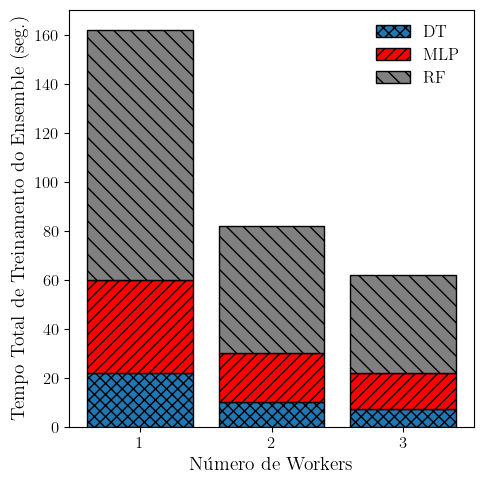

In [141]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=12)

# Dados da tabela
categories = ['1', '2', '3']

# Valores para cada classificador
dt_values = [22, 10, 7.1]
mlp_values = [38, 20, 15]
rf_values = [102, 52, 40]

# Configuração do eixo X
x = np.arange(len(categories))

# Criando o gráfico de barras empilhadas com tamanho definido
fig, ax = plt.subplots(figsize=(5, 5))

# Barras empilhadas
bar1 = ax.bar(x, dt_values, label='DT', edgecolor='black', hatch="xxx")
bar2 = ax.bar(x, mlp_values, bottom=dt_values, label='MLP', color='red', edgecolor='black', hatch="///")
# Para empilhar o RF, somamos DT + MLP
bottom_rf = [i + j for i, j in zip(dt_values, mlp_values)]
bar3 = ax.bar(x, rf_values, bottom=bottom_rf, label='RF', color='gray', edgecolor='black', hatch="\\\\")

# Labels e títulos
ax.set_xlabel('Número de Workers',fontsize=14, fontname='Times New Roman')
ax.set_ylabel('Tempo Total de Treinamento do Ensemble (seg.)', fontsize=14, fontname='Times New Roman')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(frameon=False)

# Layout ajustado
fig.tight_layout()

# Exibe o gráfico
plt.savefig('barra1.pdf', format='pdf', bbox_inches='tight')
plt.show()